# Assignment 7 - Sound localization

## Initialization

In [1]:
#importing modules
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#importing the file to Nmics and Nsamp
s = np.loadtxt("rx3.txt")

In [3]:
#number of mics and number of samples
Nmics, Nsamp = s.shape

#location of source
src = (0,0)

#spacing between microphones
pitch = 0.1

#proxy for sampling rate
dist_per_samp = 0.1

#speed of sound 
C = 2.0

#controls the "narrowness" of the sinc wave
SincP = 5       #sincP = 1 we get the first figure sincP = 5, we get the second figure

#location of mics
mics = [(0, i*pitch) for i in range(1, Nmics//2 + 1)][::-1] + [(0, -i*pitch) for i in range(1, Nmics//2 + 1)]

#location of obstacle
obstacle = (3, -1)

#sampling rate
sampling_rate = C/dist_per_samp

## Generating the source waveform

In [4]:
#function to generate source waveform - sinc pulse
def wsrc(t):
    return np.sinc(SincP*t)

In [5]:
#time axis
x_axis = np.array([i/sampling_rate for i in range(0, Nsamp)])

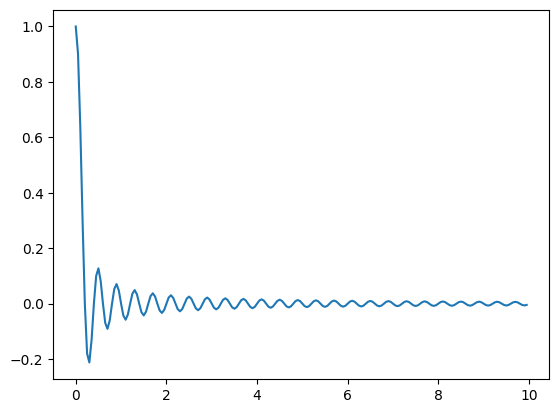

In [6]:
#source waveform
plt.plot(x_axis, wsrc(x_axis))

## Setup and generating Mic output

In [7]:
#helper function to calculate the total distance taken by the pulse
def dist(src, pt, mic):
    #distance from src to pt
    d1 = np.sqrt((src[0]-pt[0])**2 + (src[1]-pt[1])**2)
    #distance from mic to pt
    d2 = np.sqrt((mic[0]-pt[0])**2 + (mic[1]-pt[1])**2)

    return d1 + d2

In [8]:
def generate_samples(obs, x_axis, C, mics):
    lst = []
    for i in range(1, len(mics) + 1):
    # shifting the wave along x-axis by the time taken
    # shifting the wave along y - axis by the location of the mic from source (to avoid overlap)
    # multiplying the amplitude of the signal by the pitch (to fit in the plot)
        lst.append(wsrc(x_axis- (dist(src, obs, mics[i-1])/C)))
        plt.plot(x_axis, wsrc(x_axis- (dist(src, obs, mics[i-1])/C))  - i*len(mics)/100)
    return lst

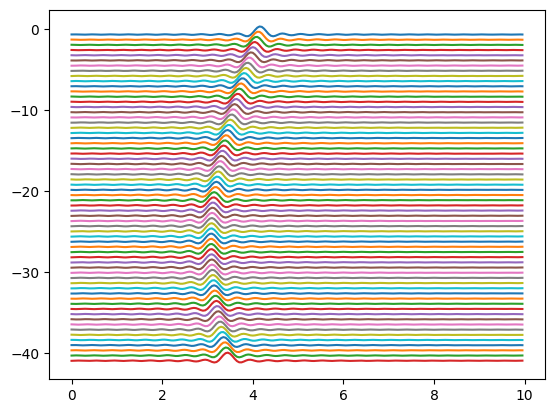

In [9]:
lst = generate_samples(obs=(3,-1), x_axis=x_axis, C = 2, mics = mics)

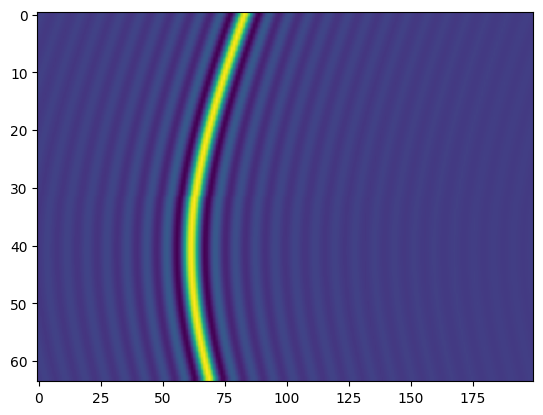

In [10]:
plt.imshow(np.array(lst), aspect='auto')

## Delay and Sum Algorithm

In [11]:
#function implementing DAS
def plot_grid1(s):
    #initialising the grid
    grid = np.zeros(shape = (Nmics, Nsamp//2))
    for i in range(Nmics):
        for j in range(0, Nsamp//2):
            summed_signal = 0
            for k in range(0,len(mics)):
                #calculating the distance
                dist_travelled = dist(src, ((j+1)*dist_per_samp, (i-Nmics//2)*pitch), mics[k])
                sample_index = int((dist_travelled) / (dist_per_samp))

                #summing over all delayed signals
                if 0 <= sample_index < Nsamp:
                    summed_signal += s[k][sample_index]
            grid[i][j] = summed_signal
    return grid


### Plotting the Reconstructed Image for the text files

In [12]:
s1 = np.loadtxt("rx2.txt")
s2 = np.loadtxt("rx3.txt")

In [13]:
#reconstruction for the given text files
grid1 = plot_grid1(s1)
grid2 = plot_grid1(s2)

C:\Users\amazi\AppData\Local\Temp\ipykernel_3148\1543098332.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


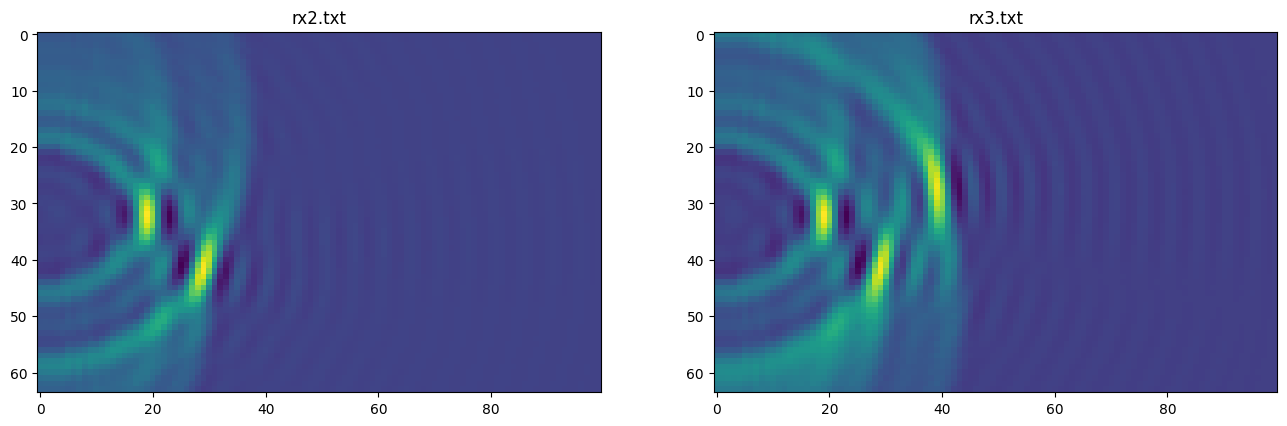

In [14]:
fig, ax = plt.subplots(1, 2, figsize = (16, 8))

ax[0].imshow(grid1)
ax[0].set_title('rx2.txt')

ax[1].imshow(grid2)
ax[1].set_title('rx3.txt')

fig.show()

### Plotting the reconstructed image for the generated set

In [15]:
#reconstruction for the generated set
grid3 = plot_grid1(np.array(lst))

Text(0.5, 1.0, 'Generated set')

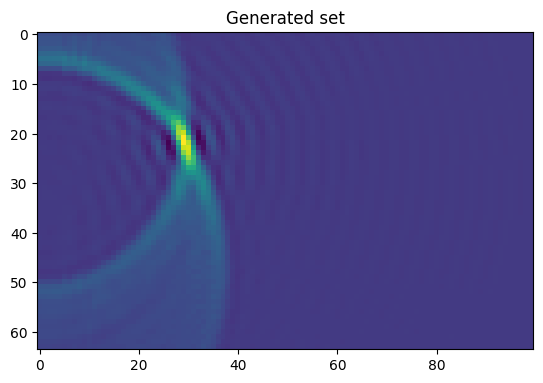

In [16]:
plt.imshow(grid3)
plt.title("Generated set")

## Detailed Explanation to In-PDF Questions

### Question 1

The plots below show two example sinc pulses. How will you generate pulses that look like this? Which parameter should be changed? What effect do you think this will have on the final image?

In [17]:
#modifing the wsrc function to parameterize sincP
def wsrc_modified(sincP, t):
    return np.sinc(sincP*t)

To generate pulses like this, we need to modify the "narrowness" of the wave. To do this, we have to change the time scaling factor, sincP. Smaller sincP will result in a more spread out wave, and larger sincP will result in a less spread out wave. (intuitively, sincP acts as frequency, more sincP, more waves in, say, 1 time unit).

Text(0.5, 1.0, 'Sinc Pulse 2: SincP = 5')

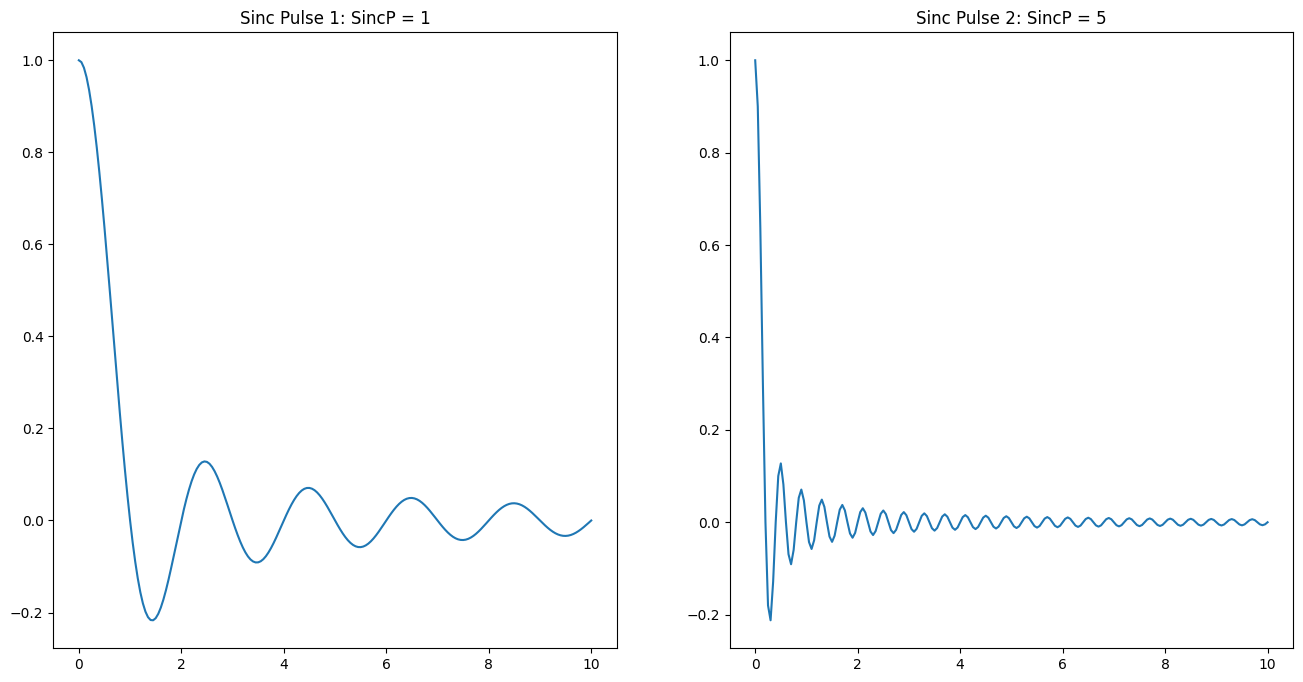

In [18]:
t_axis = np.array([i*dist_per_samp/C for i in range(0, 201)])

fig1, ax1 = plt.subplots(1, 2, figsize = (16, 8))

ax1[0].plot([i*dist_per_samp/C for i in range(0, 201)], wsrc_modified(sincP=1, t = t_axis))
ax1[0].set_title('Sinc Pulse 1: SincP = 1')

ax1[1].plot([i*dist_per_samp/C for i in range(0, 201)], wsrc_modified(sincP=5, t = t_axis))
ax1[1].set_title('Sinc Pulse 2: SincP = 5')

### Question 2

**Does it make sense to reconstruct up to Nsamp? What value is more reasonable as an upper limit for the x-axis here?**

Since, each sound wave has to travel twice, the more reasonable upper limit for x-axis would ``Nsamp``/2 which in this case would be $100$.

## Detailed Explanations to the back Questions

### Question 1

**The (x, y) coordinates corresponding to the maximum amplitude (yellow colour) is approximately (30, 22). Explain why this is the correct expected position for the given obstacle.**

The reason has to do with axes and the code. The x and y axes of the heatmap is a reflection of the indices (i, j) of the 2D reconstructed image grid. To get the actual values, you have to multiply y-axis values by `pitch` and the x-axis values by `dist_per_sample`. 

```python
for i in range(Nmics):
    for j in range(0, Nsamp//2):
        summed_signal = 0
        for k in range(0, len(mics)):
            dist_travelled = dist(src, ((j+1)*dist_per_samp, (i-Nmics//2)*pitch), mics[k])
            ### code continues

In the above code (from plot_grid function), we can observe that the y component of the distance gets calculated from `(i-Nmics//2)*pitch` which when we plug in the values for i, we get the range from (-3.2, 3.1). So, in the plot, (0, 0) corresponds to (0, -3.2) in actuality and the point, (0, 64) corresponds to (0, 3.1). 

By this logic, (30, 22) corresponds to (3.0, -1.0) on the actual distance plane. Therefore, (30, 22) is the correct expected location for this case.

### Question 2

**What is the maximum obstacle x- and y- coordinate that you can use and still have an image reconstructed?**

The maximum x-coordinate and y-coordinate must be upper limit of x-axis and upper limit of y-axis in distance plane which is ($10$, $3.2$)

### Question 3

**What happens if C is different - if C is decreased it looks like the image becomes sharper. Can you explain why intuitively?**

Intuitively speaking, if C is decreased, then, your sampling_rate increases. More sampling rate would imply that more information (rather more of the signal gets captured) which therefore leads to a better quality of the image.

The below code shows that this is indeed true.

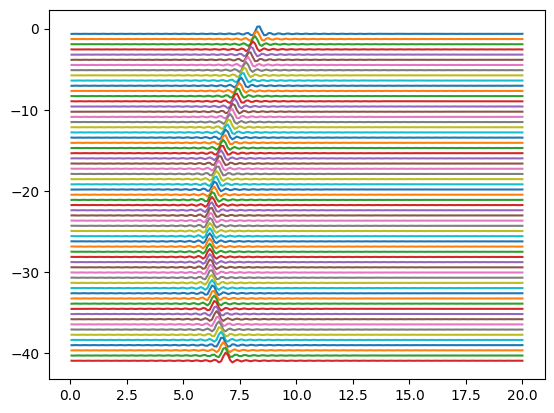

In [19]:
#speed of sound is decreased (original was C = 2)
C1 = 1
x_axis1 = np.linspace(0.05, (Nsamp*dist_per_samp)/C1, Nsamp)
lst1 = generate_samples(obs = (3, -1), x_axis=x_axis1, C = C1, mics = mics)

Text(0.5, 1.0, 'For C = 1')

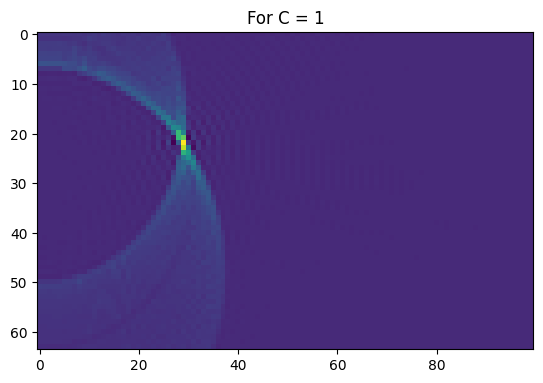

In [20]:
#reconstruction of the modified setup
grid4 = plot_grid1(np.array(lst1))
plt.imshow(grid4)
plt.title('For C = 1')

### Question 4

**What happens if Nmics is increased or decreased? Do the experiments with Nmics = [8, 32, 64] and Nsamp = [50, 100, 200] (all combinations). Attach the resulting images.**

In [21]:
#function to get location of mics depending on n_mics
def get_mics(n_mics):
    mics = [(0, i*pitch) for i in range(1, n_mics//2 + 1)][::-1] + [(0, -i*pitch) for i in range(1, n_mics//2 + 1)]
    return mics

#function to get the time axis for generating source wave and reflected waves
def get_x_axis(n_samp):
    return np.linspace(0.05, n_samp/sampling_rate, n_samp)

In [22]:
#modified to parameterize N_mics, N_samp, and the location array of mics
def plot_grid_modified(s, nmics, nsamp, mics_t):
    grid = np.zeros(shape = (nmics, nsamp//2))
    for i in range(nmics):
        for j in range(0, nsamp//2):
            summed_signal = 0
            for k in range(0,len(mics_t)):
                dist_travelled = dist(src, ((j+1)*dist_per_samp, (i-nmics//2)*pitch), mics_t[k])
                sample_index = int((dist_travelled) / (dist_per_samp))

                if 0 <= sample_index < nsamp:
                    summed_signal += s[k][sample_index]
            grid[i][j] = summed_signal
    return grid

In [23]:
#for various combinations
Nmics1 = 8
Nsamp1 = 50
Nmics2 = 8
Nsamp2 = 100
Nmics3 = 8
Nsamp3 = 200
Nmics4 = 32
Nsamp4 = 50
Nmics5 = 32
Nsamp5 = 100
Nmics6 = 32
Nsamp6 = 200
Nmics7 = 64
Nsamp7 = 50
Nmics8 = 64
Nsamp8 = 100

`Nmics = 8`, `Nsamp = 50`

Text(0.5, 1.0, 'Nsamp = 50')

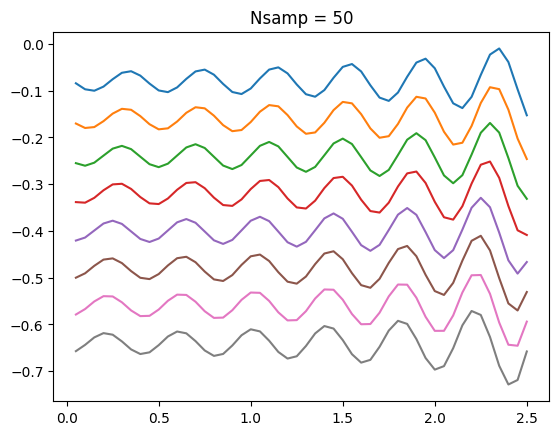

In [24]:
lst2 = generate_samples(obs = (3, -1), x_axis= get_x_axis(Nsamp1), C = C, mics = get_mics(Nmics1))
plt.title('Nsamp = 50')

Text(0.5, 1.0, 'Nmics = 8, Nsamp = 50')

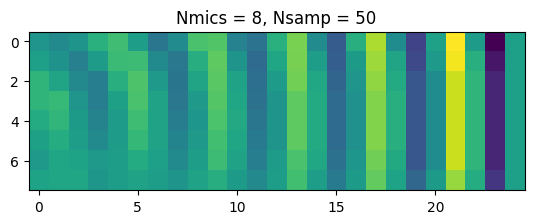

In [25]:
grid1_1 = plot_grid_modified(lst2, nmics=Nmics1, nsamp=Nsamp1, mics_t = get_mics(n_mics=Nmics1))
plt.imshow(grid1_1)
plt.title('Nmics = 8, Nsamp = 50')

`Nmics = 8`, `Nsamp = 100`

Text(0.5, 1.0, 'Nsamp = 100')

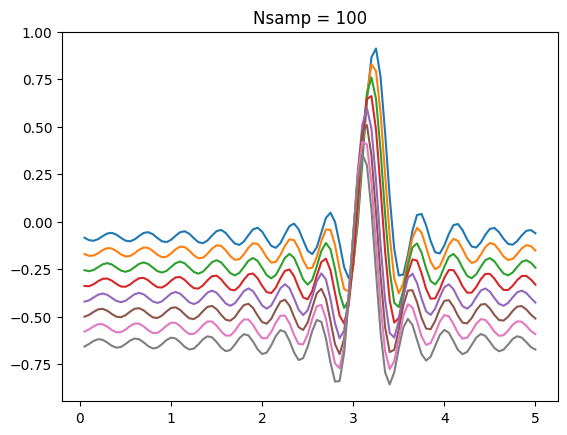

In [26]:
lst3 = generate_samples(obs = (3, -1), x_axis= get_x_axis(Nsamp2), C = C, mics = get_mics(Nmics2))
plt.title('Nsamp = 100')

Text(0.5, 1.0, 'Nmics = 8, Nsamp = 100')

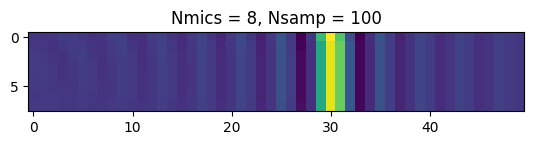

In [27]:
grid1_2 = plot_grid_modified(lst3, nmics=Nmics2, nsamp=Nsamp2, mics_t = get_mics(n_mics=Nmics2))
plt.imshow(grid1_2)
plt.title('Nmics = 8, Nsamp = 100')

`Nmics = 8`,`Nsamp = 200`

Text(0.5, 1.0, 'Nsamp = 200')

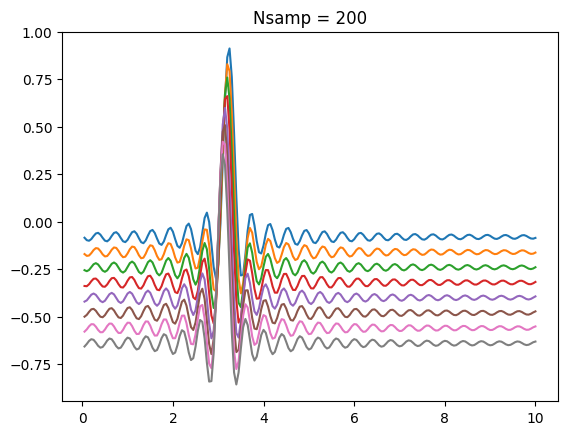

In [28]:
lst4 = generate_samples(obs = (3, -1), x_axis= get_x_axis(Nsamp3), C = C, mics = get_mics(Nmics3))
plt.title('Nsamp = 200')

Text(0.5, 1.0, 'Nmics = 8, Nsamp = 200')

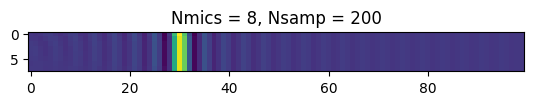

In [29]:
grid1_3 = plot_grid_modified(lst4, nmics=Nmics3, nsamp=Nsamp3, mics_t = get_mics(n_mics=Nmics3))
plt.imshow(grid1_3)
plt.title('Nmics = 8, Nsamp = 200')

`Nmics = 32`,`Nsamp = 50`

Text(0.5, 1.0, 'Nsamp = 50')

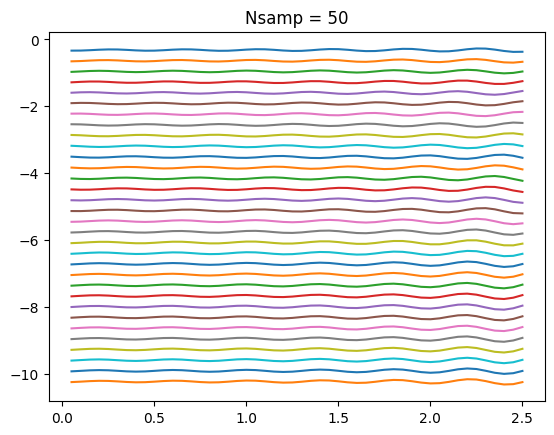

In [30]:
lst5 = generate_samples(obs = (3, -1), x_axis= get_x_axis(Nsamp4), C = C, mics = get_mics(Nmics4))
plt.title('Nsamp = 50')

Text(0.5, 1.0, 'Nmics = 32, Nsamp = 50')

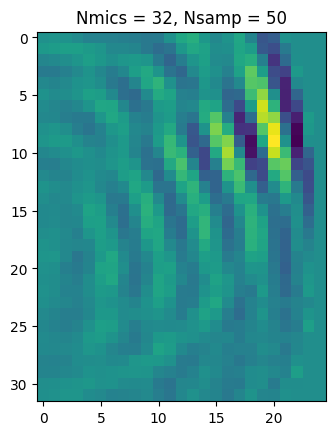

In [31]:
grid2_1 = plot_grid_modified(lst5, nmics=Nmics4, nsamp=Nsamp4, mics_t = get_mics(n_mics=Nmics4))
plt.imshow(grid2_1)
plt.title('Nmics = 32, Nsamp = 50')

`Nmics = 32`, `Nsamp = 100`

Text(0.5, 1.0, 'Nsamp = 100')

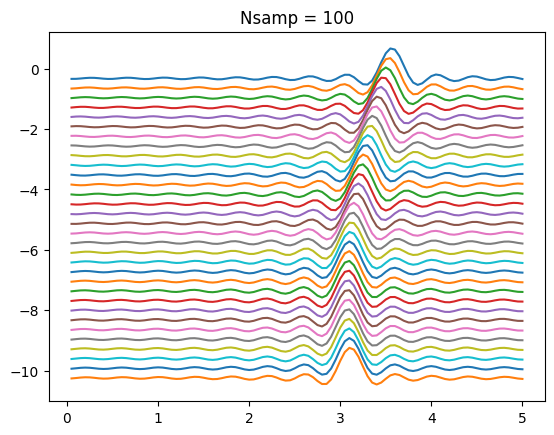

In [32]:
lst6 = generate_samples(obs = (3, -1), x_axis= get_x_axis(Nsamp5), C = C, mics = get_mics(Nmics5))
plt.title('Nsamp = 100')

Text(0.5, 1.0, 'Nmics = 32, Nsamp = 100')

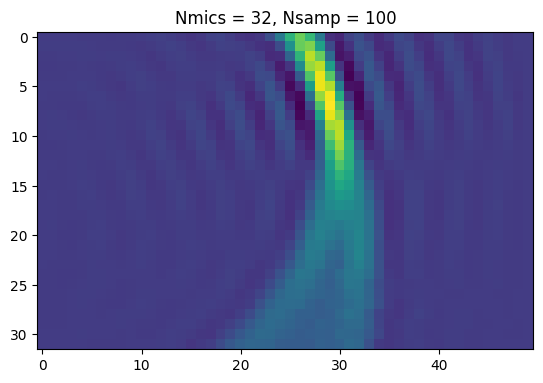

In [33]:
grid2_2 = plot_grid_modified(lst6, nmics=Nmics5, nsamp=Nsamp5, mics_t = get_mics(n_mics=Nmics5))
plt.imshow(grid2_2)
plt.title('Nmics = 32, Nsamp = 100')

`Nmics = 32`, `Nsamp = 200`

Text(0.5, 1.0, 'Nsamp = 200')

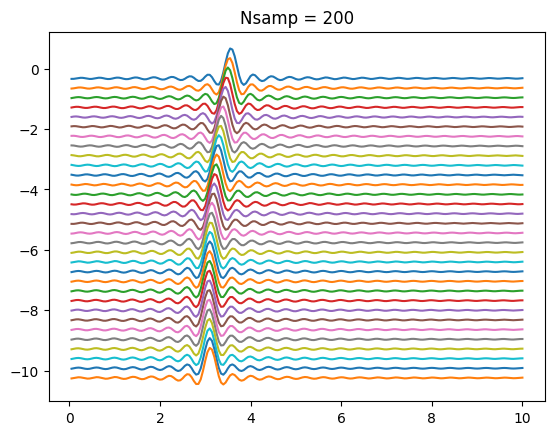

In [34]:
lst7 = generate_samples(obs = (3, -1), x_axis= get_x_axis(Nsamp6), C = C, mics = get_mics(Nmics6))
plt.title('Nsamp = 200')

Text(0.5, 1.0, 'Nmics = 32, Nsamp = 200')

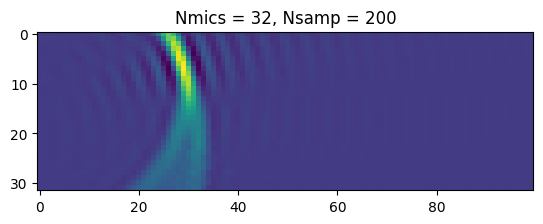

In [35]:
grid2_3 = plot_grid_modified(lst7, nmics=Nmics6, nsamp=Nsamp6, mics_t = get_mics(n_mics=Nmics6))
plt.imshow(grid2_3)
plt.title('Nmics = 32, Nsamp = 200')

`Nmics = 64`,`Nsamp = 50`

Text(0.5, 1.0, 'Nsamp = 50')

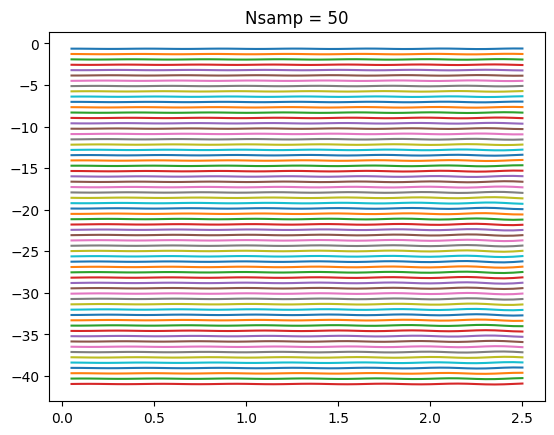

In [36]:
lst8 = generate_samples(obs = (3, -1), x_axis= get_x_axis(Nsamp7), C = C, mics = get_mics(Nmics7))
plt.title('Nsamp = 50')

Text(0.5, 1.0, 'Nmics = 64, Nsamp = 50')

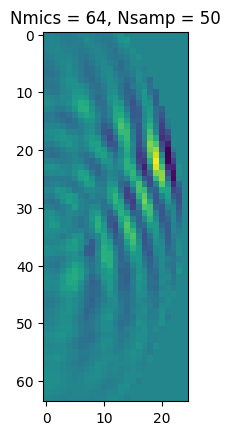

In [37]:
grid3_1 = plot_grid_modified(lst8, nmics=Nmics7, nsamp=Nsamp7, mics_t = get_mics(n_mics=Nmics7))
plt.imshow(grid3_1)
plt.title('Nmics = 64, Nsamp = 50')

`Nmics = 64`,`Nsamp = 100`

Text(0.5, 1.0, 'Nsamp = 100')

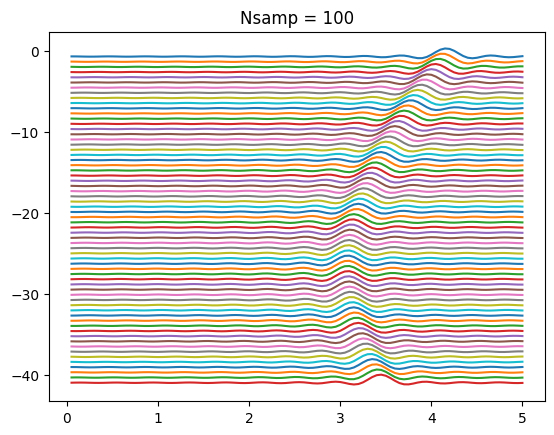

In [38]:
lst9 = generate_samples(obs = (3, -1), x_axis= get_x_axis(Nsamp8), C = C, mics = get_mics(Nmics8))
plt.title('Nsamp = 100')

Text(0.5, 1.0, 'Nmics = 64, Nsamp = 100')

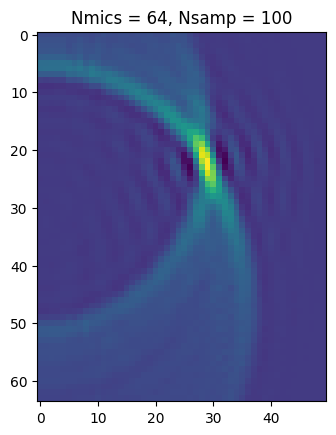

In [39]:
grid3_2 = plot_grid_modified(lst9, nmics=Nmics8, nsamp=Nsamp8, mics_t = get_mics(n_mics=Nmics8))
plt.imshow(grid3_2)
plt.title('Nmics = 64, Nsamp = 100')

`Nmics = 64`,`Nsamp = 200`

Text(0.5, 1.0, 'Nsamp = 200')

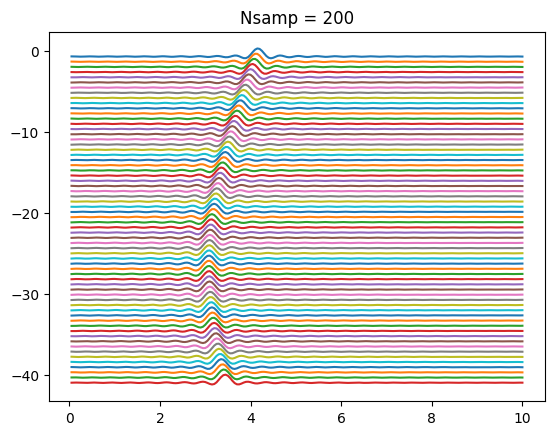

In [40]:
lst10 = generate_samples(obs = (3, -1), x_axis= get_x_axis(Nsamp), C = C, mics = get_mics(Nmics))
plt.title('Nsamp = 200')

Text(0.5, 1.0, 'Nmics = 64, Nsamp = 200')

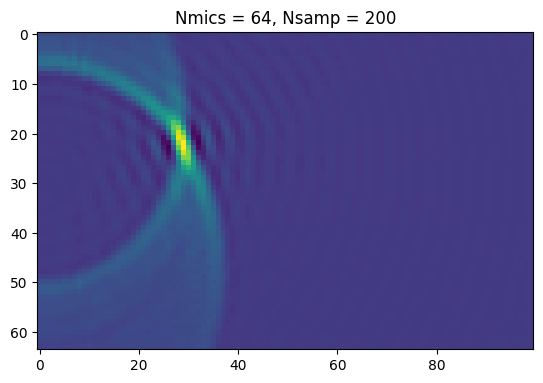

In [41]:
grid3_3 = plot_grid_modified(lst10, nmics=Nmics, nsamp=Nsamp, mics_t = get_mics(n_mics=Nmics))
plt.imshow(grid3_3)
plt.title('Nmics = 64, Nsamp = 200')

From the above plots it is evident, that more microphones (`Nmics`) and higher number of samples (`Nsamp`) results in better accuracy of the obstacle position estimate. 

The above plots have been put together for summary.

Text(0.5, 1.0, 'Nmics = 64, \nNsamp = 200')

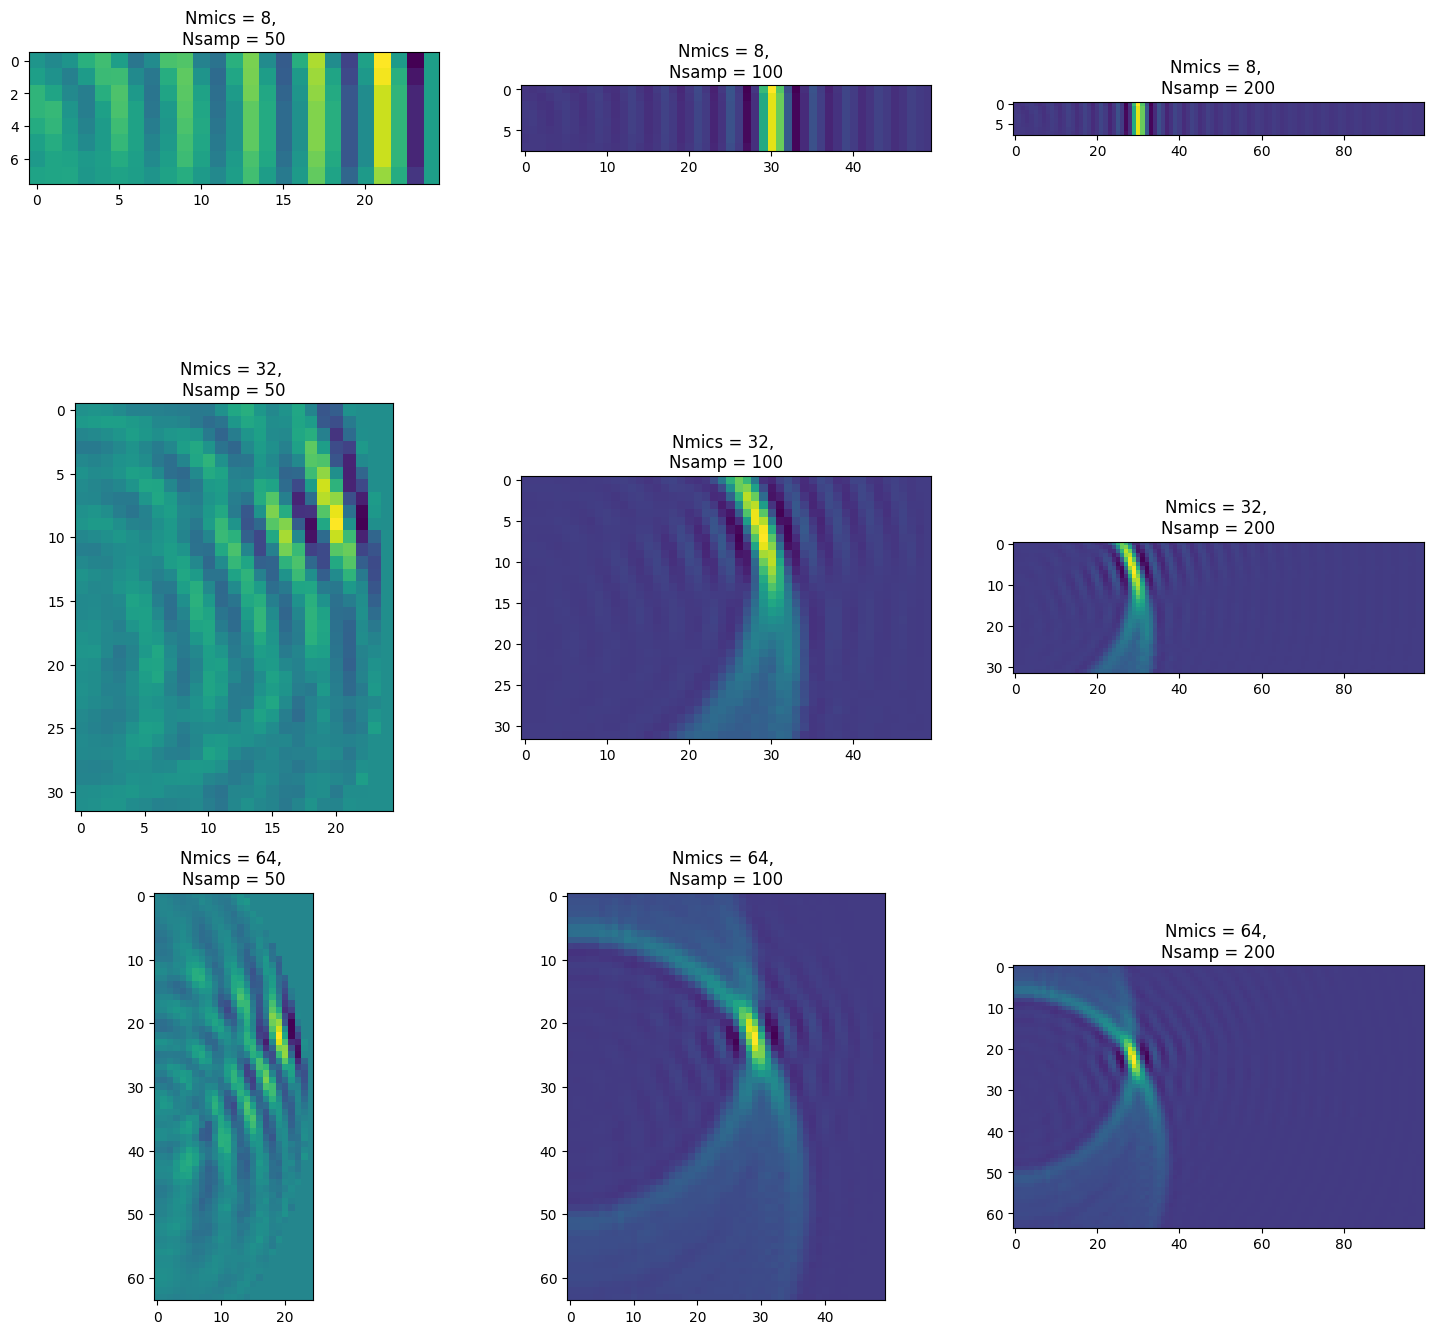

In [42]:
fig2, ax2 = plt.subplots(3, 3, figsize = (18, 18))
ax2[0, 0].imshow(grid1_1)
ax2[0, 0].set_title('Nmics = 8, \nNsamp = 50')
ax2[0, 1].imshow(grid1_2)
ax2[0, 1].set_title('Nmics = 8, \nNsamp = 100')
ax2[0, 2].imshow(grid1_3)
ax2[0, 2].set_title('Nmics = 8, \nNsamp = 200')

ax2[1, 0].imshow(grid2_1)
ax2[1, 0].set_title('Nmics = 32, \nNsamp = 50')
ax2[1, 1].imshow(grid2_2)
ax2[1, 1].set_title('Nmics = 32, \nNsamp = 100')
ax2[1, 2].imshow(grid2_3)
ax2[1, 2].set_title('Nmics = 32, \nNsamp = 200')

ax2[2, 0].imshow(grid3_1)
ax2[2, 0].set_title('Nmics = 64, \nNsamp = 50')
ax2[2, 1].imshow(grid3_2)
ax2[2, 1].set_title('Nmics = 64, \nNsamp = 100')
ax2[2, 2].imshow(grid3_3)
ax2[2, 2].set_title('Nmics = 64, \nNsamp = 200')

Text(0.5, 1.0, 'Nmics = 64, \nNsamp = 200')

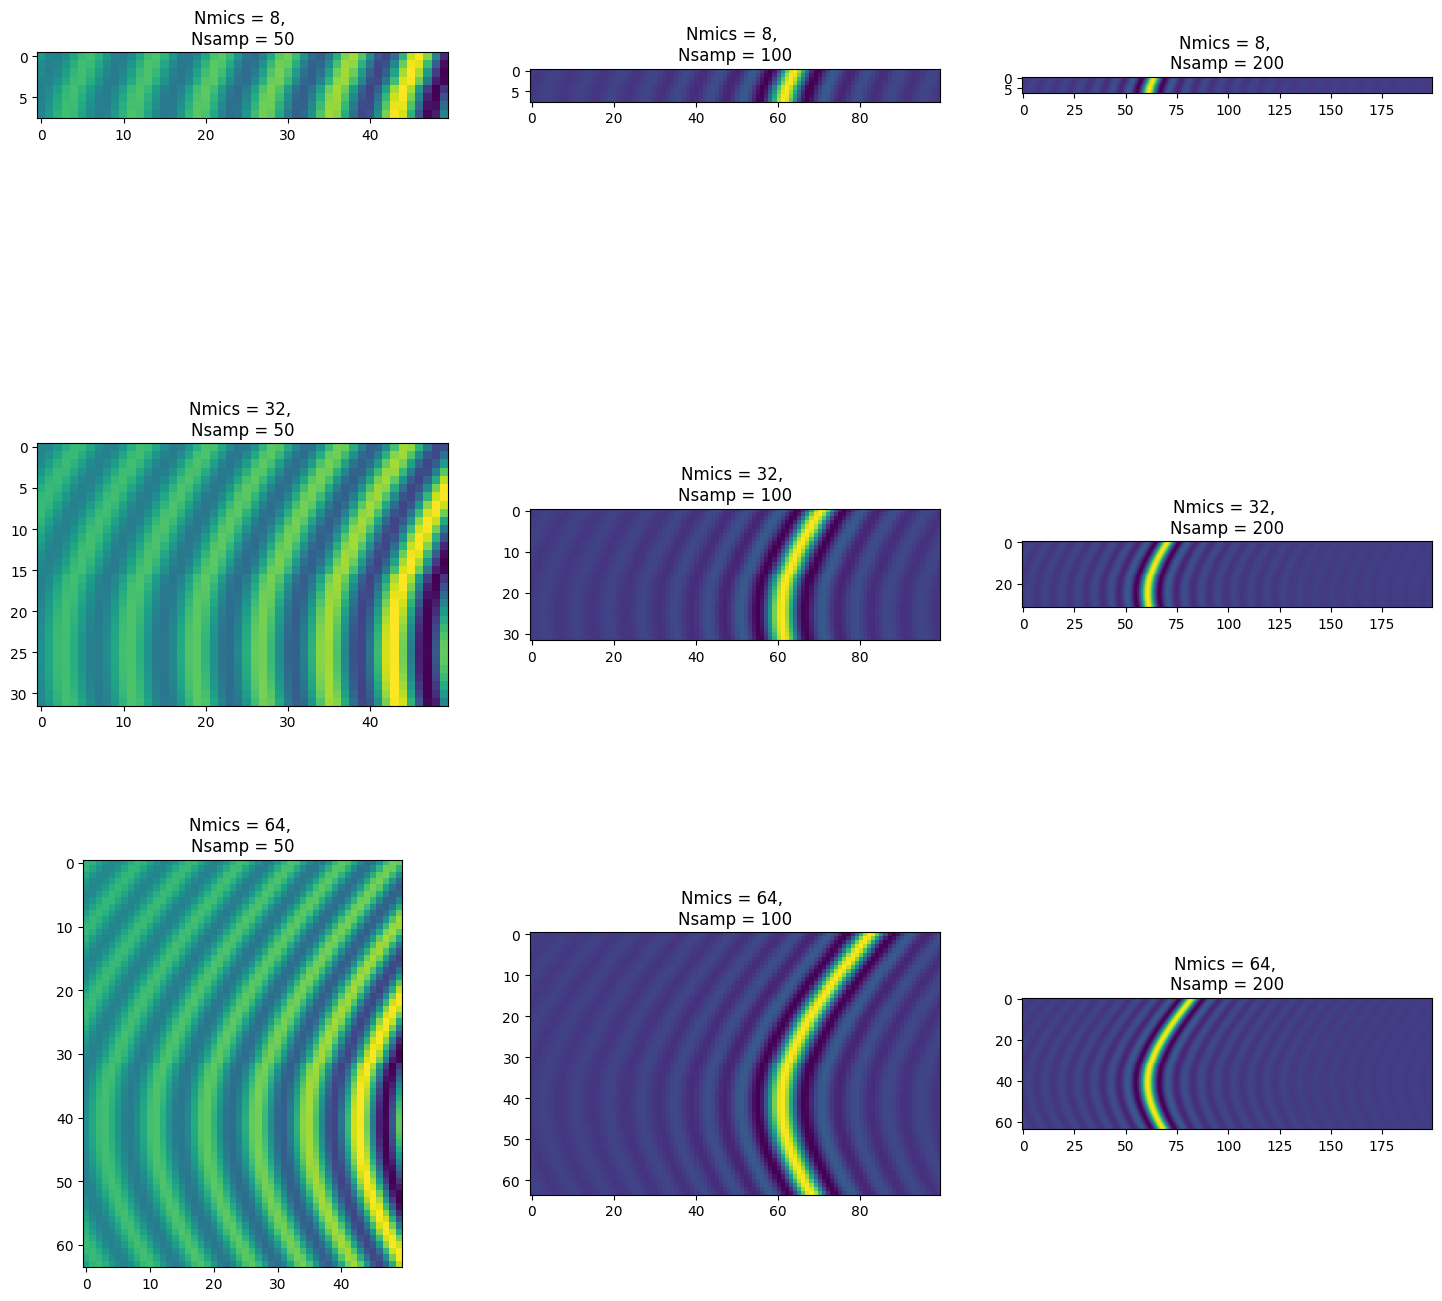

In [43]:
fig3, ax3 = plt.subplots(3, 3, figsize = (18, 18))
ax3[0, 0].imshow(lst2)
ax3[0, 0].set_title('Nmics = 8, \nNsamp = 50')
ax3[0, 1].imshow(lst3)
ax3[0, 1].set_title('Nmics = 8, \nNsamp = 100')
ax3[0, 2].imshow(lst4)
ax3[0, 2].set_title('Nmics = 8, \nNsamp = 200')

ax3[1, 0].imshow(lst5)
ax3[1, 0].set_title('Nmics = 32, \nNsamp = 50')
ax3[1, 1].imshow(lst6)
ax3[1, 1].set_title('Nmics = 32, \nNsamp = 100')
ax3[1, 2].imshow(lst7)
ax3[1, 2].set_title('Nmics = 32, \nNsamp = 200')

ax3[2, 0].imshow(lst8)
ax3[2, 0].set_title('Nmics = 64, \nNsamp = 50')
ax3[2, 1].imshow(lst9)
ax3[2, 1].set_title('Nmics = 64, \nNsamp = 100')
ax3[2, 2].imshow(lst10)
ax3[2, 2].set_title('Nmics = 64, \nNsamp = 200')